In [63]:
import os
import pandas as pd
import re
import cupy as np
import multiprocessing
import umap
import pickle
import module1_Preprocessing as module1
import module2_FeatureExtraction as module2
from functools import partial

os.chdir('../')
kaggle_path = os.path.join('Raw','Kaggle','mbti_1.csv')
reddit_path = os.path.join('Raw','Reddit','mbti9k_comments.csv')
reddit_nodup_path = os.path.join('Raw','Reddit','mbti9k_nodup.csv')
seed=123

### Load Dataset

#### Load Kaggle dataset

In [10]:
%%time
kaggle = pd.read_csv(kaggle_path,header=0, names=['MBTI','post'])
kaggle['post'] = kaggle['post'].apply(lambda x: x.strip("'"))
# kaggle_clean=module1.basicpreprocessing(kaggle,'post')
kaggle.head()

Wall time: 506 ms


,MBTI,post
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw|||h...
1,ENTP,I'm finding the lack of me in these posts very...
2,INTP,Good one _____ https://www.youtube.com/watc...
3,INTJ,"Dear INTP, I enjoyed our conversation the ot..."
4,ENTJ,You're fired.|||That's another silly misconcep...


In [3]:
# Show that the post contains data leakage keywords
MBTIcheatList=(([(len(re.findall(r'\b{}s?\b|\b{}s?\b'.format(df['MBTI'].upper(),df['MBTI'].lower())*i,df['post']))) for i, df in kaggle.iterrows()]))

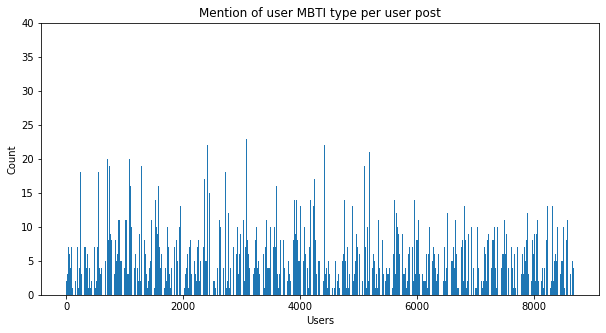

In [9]:
import matplotlib.pyplot as plt
plt.clf
plt.figure(figsize=(10,5))
plt.bar(np.asnumpy(np.arange(len(MBTIcheatList))),MBTIcheatList)
plt.xlabel('Users')
plt.ylabel('Count')
plt.title('Mention of user MBTI type per user post')
plt.ylim(0,40)
plt.savefig('MBTImentionperuser.png',format='png')
plt.show()

#### Load Reddit Dataset

In [51]:
reddit = pd.read_csv(reddit_path)
print('total duplicated user:',(reddit['author'].duplicated(keep=False)).sum())

total duplicated user: 206


In [52]:
reddit_nodup=reddit[-reddit['author'].duplicated(keep=False)].reset_index(drop=True)[['type','comment']]
# reddit_nodup.tocsv(reddit_nodup_path)
reddit_nodup.head()

,type,comment
0,entp,Yes! Personally I feel that as helpful as it i...
1,intj,I guess I'd stick to being a lesbian so I woul...
2,intp,"What languages do you speak? Whoops, my bad fo..."
3,entp,It is just arguing semantics. To many on the c...
4,entj,Come to Europe if you're interested. In many E...


### Feature Extraction

#### Tokenizing the strings then save as pickle file

In [49]:
module1.useGPU(True)

# ### load spacy
nlp = module1.loadSpacy()

Using GPU for Spacy
loading spacy en_core_web_md
finish loading


#### for Kaggle Dataset

In [3]:
for file in ['mbti_1.csv']:
    print('processing file:', file)
    
    kaggle_path = os.path.join('Source Code','Raw','Kaggle',file)
    kaggle = pd.read_csv(kaggle_path,header=0, names=['MBTI','post'])
    print('start preprocessing')
    kaggle_clean=module1.basicpreprocessing(kaggle,'post')
    kaggle_label=module1.createLabel(kaggle,'MBTI')
    print('finish preprocessing')
    del kaggle
    
    
    print('Tokenizing 1...')
    kaggle_tokens=pd.Series([module1.spacy_tokenizer(post, nlp=nlp,rm_stop=False, filterPOS=['PUNCT']) for post in kaggle_clean['post'].tolist()],
                            name='tokens') 
    
    processed_path = os.path.join('Source Code','Processed','Kaggle','Kaggle-Filtered.pickle')
    with open(processed_path, 'wb') as handle:
        kaggle_DF=pd.concat([kaggle_label,kaggle_tokens],axis=1)
        pickle.dump(kaggle_DF, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print('Tokenizing 2...')
    kaggle_tokens=pd.Series([module1.spacy_tokenizer(post, nlp=nlp,rm_stop=True, filterPOS=['PUNCT','NOUN']) for post in kaggle_clean['post'].tolist()],
                            name='tokens') 
    processed_path = os.path.join('Source Code','Processed','Kaggle','Kaggle-Filtered_noNNnoSW.pickle')
    with open(processed_path, 'wb') as handle:
        kaggle_DF=pd.concat([kaggle_label,kaggle_tokens],axis=1)
        pickle.dump(kaggle_DF, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    print('Tokenizing 3...')
    kaggle_tokens=pd.Series([module1.spacy_tokenizer(post, nlp=nlp,rm_stop=False, filterPOS=['PUNCT','NOUN']) for post in kaggle_clean['post'].tolist()],
                            name='tokens') 
    
    processed_path = os.path.join('Source Code','Processed','Kaggle','Kaggle-Filtered_noNN.pickle')
    with open(processed_path, 'wb') as handle:
        kaggle_DF=pd.concat([kaggle_label,kaggle_tokens],axis=1)
        pickle.dump(kaggle_DF, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print('Tokenizing 4...')
    kaggle_tokens=pd.Series([module1.spacy_tokenizer(post, nlp=nlp,rm_stop=True, filterPOS=['PUNCT']) for post in kaggle_clean['post'].tolist()],
                            name='tokens') 
    processed_path = os.path.join('Source Code','Processed','Kaggle','Kaggle-Filtered_noSW.pickle')
    with open(processed_path, 'wb') as handle:
        kaggle_DF=pd.concat([kaggle_label,kaggle_tokens],axis=1)
        pickle.dump(kaggle_DF, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    del kaggle_tokens
    
    print('Done...')

processing file: mbti_1.csv
start preprocessing
finish preprocessing
Tokenizing 1...
Tokenizing 2...
Tokenizing 3...
Tokenizing 4...
Done...


##### Remove rows with less than 50 tokens from kaggle dataset

In [13]:
with open('Source Code\\Processed\\Kaggle\\Kaggle-Filtered_noNNnoSW.pickle','rb') as pkl:
        DF=pickle.load(pkl)

In [19]:
with open('Source Code\\Processed\\Kaggle\\Kaggle-Filtered_noNNnoSW.pickle','rb') as pkl:
        DF=pickle.load(pkl)
        
below50index=DF['tokens'][(DF['tokens'].apply(lambda x: len(x))<50)].index.tolist()

file_list=[]
for root,subdir,files in os.walk(os.path.join('Source Code','Processed','Kaggle')):
    file_list.extend([os.path.join(root,file) for file in files if file.endswith('.pickle')])

         
for file in file_list:         
    with open('Source Code\\Processed\\Kaggle\\'+os.path.basename(file),'rb') as pkl:
        DF=pickle.load(pkl)
    DF=DF.drop(index=below50index).reset_index(drop=True)
    with open('Source Code\\Processed\\Kaggle50\\'+os.path.basename(file),'wb') as pkl:
        pickle.dump(DF, pkl, protocol=pickle.HIGHEST_PROTOCOL)


#### For Reddit Dataset

In [3]:
for file in ['mbti9k_nodup.csv']:
    print('processing file:', file)
    
    reddit_path = os.path.join('Source Code','Raw','Reddit',file)
    reddit = pd.read_csv(reddit_path,header=0, names=['MBTI','post'])
    print('start preprocessing')
    reddit_clean=module1.basicpreprocessing(reddit,'post')
    reddit_label=module1.createLabel(reddit,'MBTI')
    del reddit
    print('finish preprocessing')
    
    print('Tokenizing 1...')
    reddit_tokens=pd.Series([module1.spacy_tokenizer(post, nlp=nlp,rm_stop=False,filterPOS=['PUNCT']) for post in reddit_clean['post'].tolist()],
                            name='tokens') 
    
    processed_path = os.path.join('Source Code','Processed','Reddit','Reddit.pickle')
    with open(processed_path, 'wb') as handle:
        reddit_DF=pd.concat([reddit_label,reddit_tokens],axis=1)
        pickle.dump(reddit_DF, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    print('Tokenizing 2...')
    reddit_tokens=pd.Series([module1.spacy_tokenizer(post, nlp=nlp,rm_stop=True, filterPOS=['PUNCT','NOUN']) for post in reddit_clean['post'].tolist()],
                            name='tokens') 
    processed_path = os.path.join('Source Code','Processed','Reddit','Reddit_noNNnoSW.pickle')
    with open(processed_path, 'wb') as handle:
        reddit_DF=pd.concat([reddit_label,reddit_tokens],axis=1)
        pickle.dump(reddit_DF, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
   
    print('Tokenizing 3...')     
    reddit_tokens=pd.Series([module1.spacy_tokenizer(post, nlp=nlp,rm_stop=False,filterPOS=['PUNCT','NOUN']) for post in reddit_clean['post'].tolist()],
                            name='tokens') 
    
    processed_path = os.path.join('Source Code','Processed','Reddit','Reddit_noNN.pickle')
    with open(processed_path, 'wb') as handle:
        reddit_DF=pd.concat([reddit_label,reddit_tokens],axis=1)
        pickle.dump(reddit_DF, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    print('Tokenizing 4...')
    reddit_tokens=pd.Series([module1.spacy_tokenizer(post, nlp=nlp,rm_stop=True, filterPOS=['PUNCT']) for post in reddit_clean['post'].tolist()],
                            name='tokens') 
    processed_path = os.path.join('Source Code','Processed','Reddit','Reddit_noSW.pickle')
    with open(processed_path, 'wb') as handle:
        reddit_DF=pd.concat([reddit_label,reddit_tokens],axis=1)
        pickle.dump(reddit_DF, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    del reddit_tokens
    
    
    print('done...')

processing file: mbti9k_nodup.csv
start preprocessing
finish preprocessing


### Convert Tokens to txt file as input for LIWC software

In [20]:
file_list=[]
for root,subdir,files in os.walk(os.path.join('Source Code','Processed','Kaggle50')):
    file_list.extend([os.path.join(root,file) for file in files if file.endswith('.pickle')])
# file_list=file_list[:3]
file_list

['Source Code\\Processed\\Kaggle50\\kaggle-uncensored.pickle',
 'Source Code\\Processed\\Kaggle50\\kaggle-uncensored_noNN.pickle',
 'Source Code\\Processed\\Kaggle50\\kaggle-uncensored_noNNnoSW.pickle',
 'Source Code\\Processed\\Kaggle50\\kaggle-uncensored_noSW.pickle',
 'Source Code\\Processed\\Kaggle50\\kaggle.pickle',
 'Source Code\\Processed\\Kaggle50\\kaggle_noNN.pickle',
 'Source Code\\Processed\\Kaggle50\\kaggle_noNNnoSW.pickle',
 'Source Code\\Processed\\Kaggle50\\kaggle_noSW.pickle']

In [21]:
for file in file_list:
    with open(file,'rb') as pkl:
        DF=pickle.load(pkl)
    series_tokens=DF['tokens'].apply(lambda x: ' '.join(x))
    for i,row in enumerate(series_tokens):
        path=os.path.join('Source Code','LIWC',os.path.basename(file).replace('.pickle',''),f'row_{str(i).zfill(4)}.txt')
        if not os.path.isdir(os.path.split(path)[0]):
            os.mkdir(os.path.split(path)[0])
        with open(path,'w+', encoding='utf-8') as txt:
            txt.write(row)

### Read a converted LIWC csv for example

In [35]:
fileLIWCpath=os.path.join('Source Code','Processed','LIWC','LIWC_'+os.path.basename(file_list[0]).replace('.pickle','.csv'))
fileLIWC=pd.read_csv(fileLIWCpath)

In [57]:
fileLIWC=fileLIWC.iloc[:,3:].div(fileLIWC.iloc[:,2].tolist(), axis=0)

,Analytic,Clout,Authentic,Tone,Sixltr,function,pronoun,ppron,i,we,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,0.161323,0.135104,0.117713,0.116484,0.029660,0.095766,0.024291,0.015369,0.007146,0.000000,...,0.001437,0.000000,0.000000,0.000718,0.002136,0.000000,0.001437,0.000359,0.000359,0.000000
1,0.048400,0.041871,0.064939,0.040848,0.009091,0.048899,0.016809,0.012911,0.008636,0.000455,...,0.000000,0.000000,0.000227,0.000227,0.000385,0.000079,0.000149,0.000149,0.000000,0.000000
2,0.053117,0.074417,0.064209,0.088098,0.018221,0.065190,0.020319,0.009791,0.005423,0.000307,...,0.000147,0.000000,0.000454,0.000000,0.001055,0.000000,0.000147,0.000454,0.000147,0.000307
3,0.041499,0.053900,0.057983,0.054390,0.013746,0.055178,0.018088,0.012459,0.006647,0.001201,...,0.000183,0.000000,0.000365,0.000000,0.001287,0.000279,0.000826,0.000096,0.000096,0.000000
4,0.043960,0.068896,0.027314,0.048047,0.014650,0.059841,0.017463,0.010372,0.003949,0.000446,...,0.000117,0.000679,0.000117,0.000117,0.001242,0.000786,0.000340,0.000000,0.000117,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8632,0.071334,0.076420,0.055707,0.059670,0.017279,0.073289,0.020766,0.013435,0.006803,0.000000,...,0.000000,0.001044,0.000700,0.000528,0.002444,0.001044,0.000172,0.000528,0.000172,0.000528
8633,0.018573,0.025947,0.062069,0.074664,0.010198,0.044405,0.014336,0.010198,0.007107,0.000405,...,0.000351,0.000176,0.000061,0.000000,0.000878,0.000061,0.000290,0.000290,0.000290,0.000000
8634,0.058323,0.082522,0.042532,0.049416,0.015108,0.058680,0.018268,0.012186,0.004448,0.000942,...,0.000346,0.000238,0.000238,0.000119,0.000823,0.000346,0.000238,0.000000,0.000238,0.000000
8635,0.021267,0.015234,0.050503,0.041652,0.007573,0.035512,0.011285,0.007395,0.005435,0.000178,...,0.000036,0.000243,0.000036,0.000000,0.000243,0.000071,0.000000,0.000142,0.000036,0.000000
